In [2]:
import json
import pandas as pd
from collections import defaultdict
from nltk.tokenize import word_tokenize
import pickle
import h5py
import re
from utils import img_data_2_mini_batch, imgs2batch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torchvision import transforms
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import functools as ft

%matplotlib inline
import torch.nn.functional as F
import sys, os
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2

In [3]:
from data_loader import VQADataSet
pp = lambda parsed: print(json.dumps(parsed, indent=4, sort_keys=True))
N = 1

In [4]:
dataset_filename = "./data/data_{}.pkl".format(N)
dataset = None
print(dataset_filename)
if (os.path.exists(dataset_filename)):
    with open(dataset_filename, 'rb') as handle:
        print("reading from " + dataset_filename)
        dataset = pickle.load(handle)
else:
    dataset = VQADataSet(Q=N)
    with open(dataset_filename, 'wb') as handle:
        print("writing to " + dataset_filename)
        pickle.dump(dataset, handle)

assert(dataset is not None)

./data/data_1.pkl


100%|██████████| 1/1 [00:00<00:00, 121.79it/s]


VQADataSet init time: 10.823058843612671
writing to ./data/data_1.pkl


In [5]:
# print(len(dataset.anns))
N_sample = 4
q_keys = list(dataset.question_maps.keys())
# for q_key in q_keys[:N_sample]:
#     pp(dataset.question_maps[q_key])
# pp(dataset.answer_maps[:N_sample])
print(len(dataset.splits['test']))
print(len(dataset.splits['train']))

0
1


train: 1 test:0 percent: 1.0 total: 1
1
0


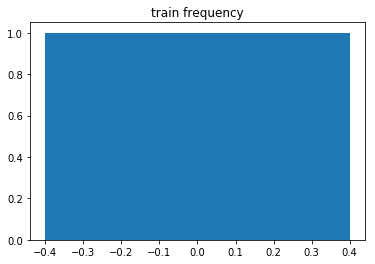

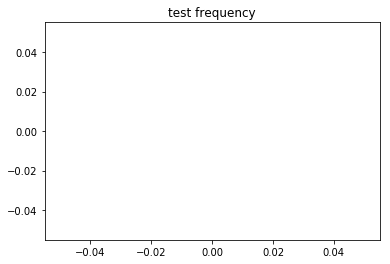

1 1


In [6]:
def plot_distribution(dataset):
    train = dataset.splits['train']
    test = dataset.splits['test']
    print('train: {} test:{} percent: {} total: {}'.format(
        len(train),
        len(test),
        len(train)/len(train+test),
        len(train) + len(test),
    ))
    def split_to_freq(split, T=None):
        anns = [dataset.answer_maps[i] for i in split]
        _cntr = defaultdict(int)
        for ann in anns:
            _cntr[ann['answer']]+=1
        tmp = sorted(_cntr.items(), key=lambda kv: kv[1], reverse=True)[:T]
        print(len(tmp))
        return [x[1] for x in tmp]

    def plot_freq(title, Y):
        X = range(len(Y))
        plt.bar(X, Y)
        plt.title(title)
        plt.show()

    train_freq = split_to_freq(train, T=50)#len(train))
    test_freq = split_to_freq(test, T=50)#(train))
    plot_freq("train frequency", train_freq)
    plot_freq("test frequency", test_freq)
    print('1', len(train_freq))

plot_distribution(dataset)

In [14]:
import torch
import tqdm
train_loader = dataset.build_data_loader(train=True, args={'batch_size': 5})
# print(len(train_loader))
for minibatch in tqdm.tqdm(train_loader):
    idxs, v,q,a,q_len = minibatch
    q = VQADataSet.batchify_questions(q)
    batch_size = len(q_len)
    print("\nminibatch:")
    print('idx', idxs)
    print('v: ', v.shape)
    print('a: ', a)
    print('q: ', q)
    print('len: ', q_len)
    for i in range(batch_size):
        idx_i = idxs[i]
        q_i = q[i]
        a_i = a[i].item()
        v_i = v[i].numpy()
        q_len_i = q_len[i]
        qj, aj = dataset.get(idx_i, 'train')
        print(qj)
        qj_check = dataset.decode_question(q_i.tolist())
        qj_ans = " ".join(qj['tokens'])
        aj_check = str(dataset.decode_answer(a_i))
        aj_ans = str(aj['answer'])
        print(idx_i.item(), q_len_i)
        print("\tcheck: " + qj_check + " " + str(len(qj['tokens'])))
        print("\tanswer: " + qj_ans)
        print("\tcheck: " + aj_check)
        print("\tanswer: " + aj_ans)
        assert(aj_ans == aj_check)
        assert(qj_ans in qj_check)
        img_v = v_i
        img_v = Image.open(qj['image_path'])
        print(img_v)
#         img_v = img_v.reshape(224, 224, 3)
#         imshow(img_v[0,:,:], interpolation='nearest')
        break
    break
    


  0%|          | 0/1 [00:00<?, ?it/s]

batch_size: 5 shuffle: True

minibatch:
idx tensor([0])
v:  torch.Size([1, 3, 224, 224])
a:  tensor([0])
q:  tensor([[1, 7, 8, 5, 4, 6, 2]])
len:  tensor([7])
{'image_id': 262148, 'question': 'Where is he looking?', 'question_id': 262148000, 'tokens': ['<start>', 'where', 'is', 'he', 'looking', '?', '<end>'], 'encoding': [1, 7, 8, 5, 4, 6, 2], 'image_path': 'data/val2014/COCO_val2014_000000262148.jpg'}
0 tensor(7)
	check: <start> where is he looking ? <end> 7
	answer: <start> where is he looking ? <end>
	check: down
	answer: down
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x512 at 0x2AAB1682E8D0>


In [9]:
print(dataset.size())

(1, 1)


In [10]:
x= 'data/val2014/COCO_val2014_000000262274.jpg'

print(os.path.exists(x))


True


In [11]:
#https://arxiv.org/pdf/1803.07724.pdf

In [12]:
# # pp(dataset.answer_maps)
# from random import shuffle
# from collections import defaultdict
# cntr = defaultdict(int)
# dist = defaultdict(list)
# for i, ann in enumerate(dataset.answer_maps):
#     ans = ann['answer']
#     cntr[ans]+=1
#     dist[ans].append(i)
#     split = {'train': [], 'test': []}
#     z_cnt = 0
#     for ans, idxes in dist.items():
#         shuffle(idxes)
#         c = int(len(idxes)*0.20)
#         split['train'] += idxes[c:]
#         split['test'] += idxes[:c]
#     split['test'].sort()
#     print(split['test'][:20])

In [13]:
print(dataset.itoq[0])
print(dataset.itoq[1])
print(dataset.itoq[2])
print(dataset.itoq[3])

print(dataset.qtoi['<pad>'])
print(dataset.qtoi['<start>'])
print(dataset.qtoi['<end>'])
print(dataset.qtoi['<unk>'])

<pad>
<start>
<end>
<unk>
0
1
2
3
